In [2]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
credits = pd.read_csv('../input/tmdb_5000_credits.csv', sep=',')
movies = pd.read_csv('../input/tmdb_5000_movies.csv', sep=',')

In [4]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [6]:
movies[['budget','revenue','vote_count','popularity']].max(axis=0)

budget        3.800000e+08
revenue       2.787965e+09
vote_count    1.375200e+04
popularity    8.755813e+02
dtype: float64

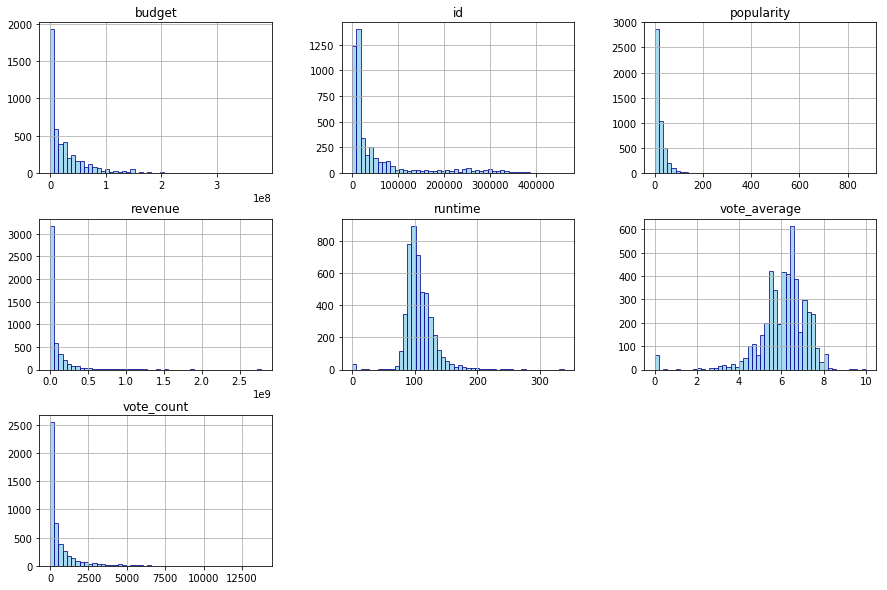

In [7]:
hist = movies.hist(bins=50, figsize = (15,10),
                   facecolor='skyblue', ec="darkblue", alpha=0.75)

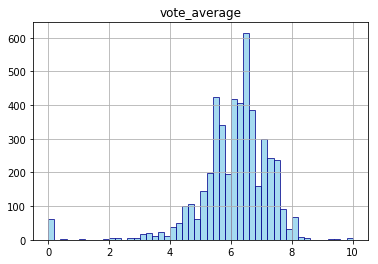

In [8]:
hist = movies.hist(column=["vote_average"], bins=50, 
                   facecolor='skyblue', ec="darkblue", alpha=0.75)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



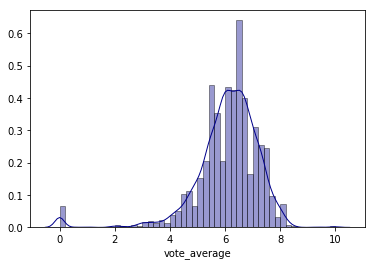

In [9]:
sns.distplot(movies['vote_average'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

scipy.stats.norm.pdf



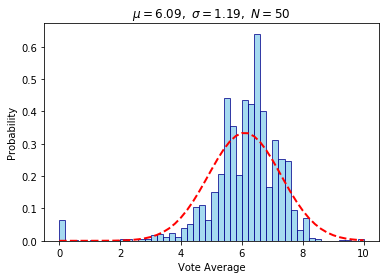

In [10]:
n, bins, patches = plt.hist(movies['vote_average'], 
                            50, normed=1, 
                            facecolor='skyblue', ec="darkblue", alpha=0.75)

sigma = movies['vote_average'].std(axis=0)
mu =  movies['vote_average'].mean(axis=0)
plt.plot(bins, mlab.normpdf(bins, mu, sigma),
             'r--', linewidth=2)

plt.xlabel('Vote Average')
plt.ylabel('Probability')
plt.title(r'$\mu=%.2f,\ \sigma=%.2f,\ N=%i$' %(mu, sigma, bins.shape[0]-1))
plt.show()

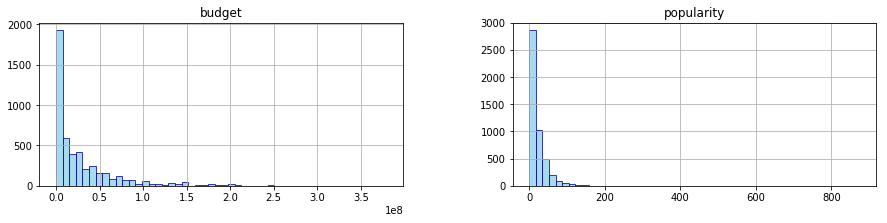

In [11]:
hist = movies.hist(column=["popularity","budget"], bins=50, figsize = (15,3),
                   facecolor='skyblue', ec="darkblue", alpha=0.75)

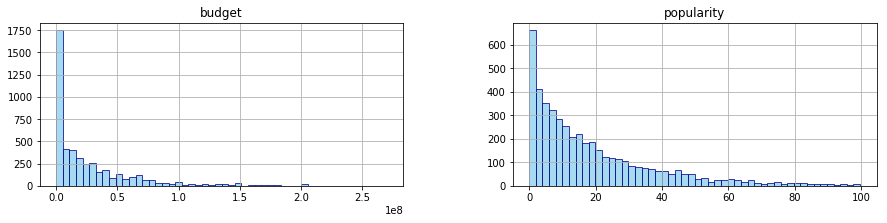

In [12]:
hist = movies \
.loc[(movies['popularity']<100) & (movies['budget']<0.3E9)] \
.hist(
    column=["popularity","budget"], 
    bins=50, figsize = (15,3),
    facecolor='skyblue', ec="darkblue", alpha=0.75)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



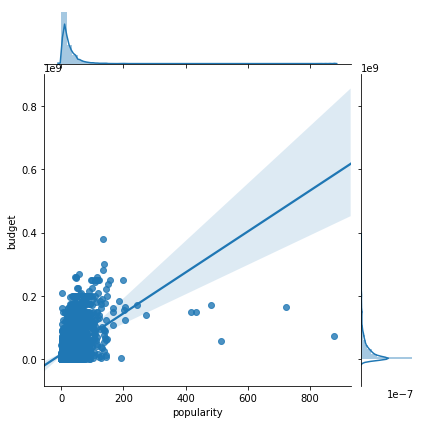

In [13]:
g = sns.JointGrid(x="popularity", y="budget", data=movies)
g = g.plot(sns.regplot, sns.distplot)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



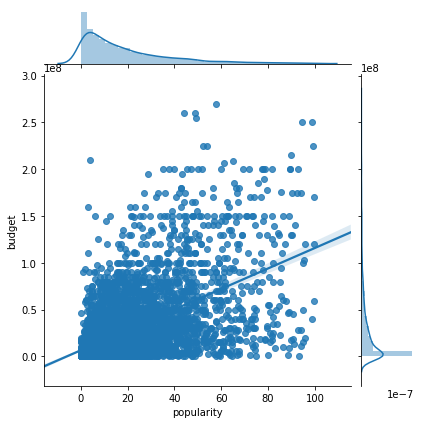

In [14]:
g = sns.JointGrid(x="popularity", y="budget", data=movies.loc[(movies['popularity']<100) & (movies['budget']<0.3E9)])
g = g.plot(sns.regplot, sns.distplot)

In [15]:
split = 0.8
msk = np.random.rand(len(movies)) < split

movies_shuff = movies.sample(frac=1).reset_index(drop=True)

train_labels = movies_shuff.loc[msk, movies_shuff.columns =='popularity']
train_data   = movies_shuff.loc[msk, movies_shuff.columns =='budget']

test_labels = movies_shuff.loc[~msk, movies_shuff.columns =='popularity']
test_data   = movies_shuff.loc[~msk, movies_shuff.columns =='budget']

In [16]:
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data  = (test_data - mean) / std

In [17]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

In [18]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=500,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop])

In [20]:
test_predictions = model.predict(test_data)

print(test_predictions[0:5])
test_labels[0:5]

[[31.218363]
 [18.842968]
 [18.842968]
 [ 8.557437]
 [35.304638]]


,popularity
3,32.015477
4,95.130041
5,32.690038
6,0.197264
11,22.392544


In [21]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()

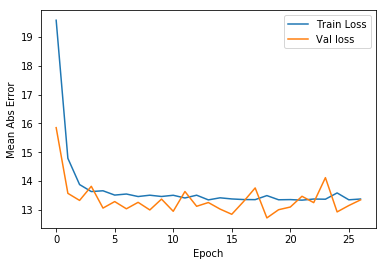

In [22]:
plot_history(history)

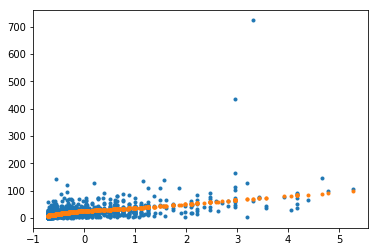

In [23]:
line = plt.figure();
plt.plot(test_data, test_labels, ".");
plt.plot(test_data, test_predictions, '.');

In [ ]:
def build_model_2():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(1)
  ])
  optimizer = tf.train.RMSPropOptimizer(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model_2 = build_model_2()
model_2.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model_2.fit(train_data, train_labels, epochs=500,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop])
test_predictions_2 = model_2.predict(test_data)

In [ ]:
line = plt.figure()
plt.plot(test_data, test_labels, ".")
plt.plot(test_data, test_predictions, '.')
plt.plot(test_data, test_predictions_2, 'o', mfc='none', markersize=10);

In [ ]:
def build_model_3():
  model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(1)
  ])
  optimizer = tf.train.RMSPropOptimizer(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model_3 = build_model_3()
model_3.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model_3.fit(train_data, train_labels, epochs=500,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop])
test_predictions_3 = model_3.predict(test_data)

In [ ]:
line = plt.figure()
plt.xlabel('budget')
plt.ylabel('popularity')
plt.plot(test_data, test_labels, ".")
plt.plot(test_data, test_predictions, '.')
plt.plot(test_data, test_predictions_2, 'o', mfc='none', markersize=10)
plt.plot(test_data, test_predictions_3, 'x', mfc='none', markersize=10);